BloomTech Data Science

*Unit 2, Sprint 2, Module 1*

---

# Module Project: Decision Trees

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or functional needs repair.


## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Join the kaggle competition, and download the water pump dataset.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and validation sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `ydata-profiling`
- `sklearn`

In [1]:
%%capture
!pip install category_encoders==2.*
!pip install ydata_profiling==4.*

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [5]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [8]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
!kaggle competitions download -c bloomtech-water-pump-challenge

bloomtech-water-pump-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!unzip \*.zip  && rm *.zip

Archive:  bloomtech-water-pump-challenge.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test_features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test_features.csv       
  inflating: train_features.csv      
  inflating: train_labels.csv        


In [10]:
!ls

kaggle.json	    sample_submission.csv  train_features.csv  Untitled0.ipynb
new_submission.csv  test_features.csv	   train_labels.csv


In [25]:
#train_features = pd.read_csv('train_features.csv')
#train_labels = pd.read_csv('train_labels.csv')
#test_features = pd.read_csv('test_features.csv')

train_features = "https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Kaggle-Challenge/main/data/waterpumps/train_features.csv"
train_labels = "https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Kaggle-Challenge/main/data/waterpumps/train_labels.csv"
test_features = "https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Kaggle-Challenge/main/data/waterpumps/test_features.csv"

# Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. **We recommend that you choose a username that's based on your name, since you might include it in your resume in the future.** Go to our Kaggle competition website (the URL is given on Canvas). Go to the **Rules** page. Accept the rules of the competition and download the dataset. Notice that the **Rules** page also has instructions for the Submission process. The **Data** page has feature definitions.

# I. Wrangle Data

In [26]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

**Task 1:** Using the `wrangle` function above, read the `train_features.csv` and  `train_labels.csv` files into the DataFrame `df`. Next, use the same function to read the test set `test_features.csv` into the DataFrame `X_test`.

In [28]:
df = wrangle(train_features, train_labels)
X_test = wrangle(test_features)

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [29]:
target = 'status_group'
X = df.drop(columns=target)
y = df[target]

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [32]:
baseline_acc = y_train.value_counts(normalize= True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425829668132747


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_dt`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `DecisionTreeClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `DecisionTreeClassifier`.

In [34]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier()
)

model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
                                          'mapping': communal standpipe             1
hand pump                      2
other                          3
communal standpipe multiple    4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': communal standpipe    1
hand pump             2
other                 3
improved spring       4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_dt`.

In [35]:
training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9952650518739873
Validation Accuracy Score: 0.7502525252525253


# VI. Tune Model

**Task 8:** Is there a large difference between your training and validation accuracy? If so, experiment with different setting for `max_depth` in your `DecisionTreeClassifier` to reduce the amount of overfitting in your model.

In [37]:
# Use this cell for experimentation and then change your model hyperparameters in Task 6
depth_number = []
val_acc_amount = []

for depth in range(1, 50):
    model_dt = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(),
       DecisionTreeClassifier(max_depth=depth)
    )

    model_dt.fit(X_train, y_train)

    training_acc = accuracy_score(y_train, model_dt.predict(X_train))
    val_acc = accuracy_score(y_val, model_dt.predict(X_val))
    depth_number.append(depth)
    val_acc_amount.append(val_acc)

    print('Training Accuracy Score:', training_acc)
    print('Validation Accuracy Score:', val_acc)
    print('----------------')

Training Accuracy Score: 0.6476356825690777
Validation Accuracy Score: 0.6505050505050505
----------------
Training Accuracy Score: 0.6892821818640965
Validation Accuracy Score: 0.6896464646464646
----------------
Training Accuracy Score: 0.696437214587849
Validation Accuracy Score: 0.696969696969697
----------------
Training Accuracy Score: 0.7089795660683095
Validation Accuracy Score: 0.7121212121212122
----------------
Training Accuracy Score: 0.7176287379784928
Validation Accuracy Score: 0.718013468013468
----------------
Training Accuracy Score: 0.7252888318356868
Validation Accuracy Score: 0.723989898989899
----------------
Training Accuracy Score: 0.7312443443675162
Validation Accuracy Score: 0.7289562289562289
----------------
Training Accuracy Score: 0.7436393863507229
Validation Accuracy Score: 0.7384680134680135
----------------
Training Accuracy Score: 0.7551716155643006
Validation Accuracy Score: 0.7453703703703703
----------------
Training Accuracy Score: 0.76811380710873

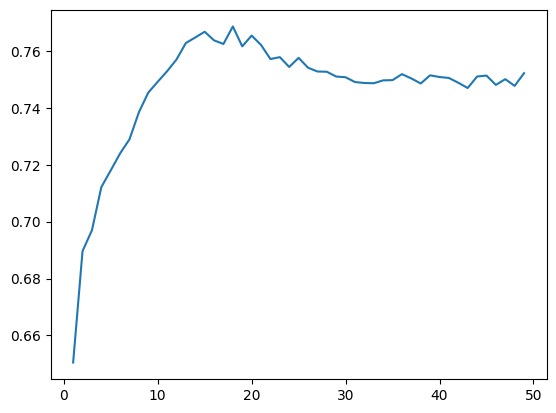

In [38]:
plt.plot(depth_number, val_acc_amount)

In [39]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(max_depth=14)
    )

model_dt.fit(X_train, y_train)

training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))
print(training_acc, val_acc)

0.835160672573076 0.7651515151515151


# VII. Communicate Results

**Task 9 `stretch goal`:** Create a horizontal barchart that shows the the 10 most important features for model_dt, sorted by value.

**Note:** [`DecisionTreeClassifier.feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreecla#sklearn.tree.DecisionTreeClassifier.feature_importances_) returns values that are different from [`LogisticRegression.coef_`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). All the values will be positive, and they will sum to `1`.

<Axes: >

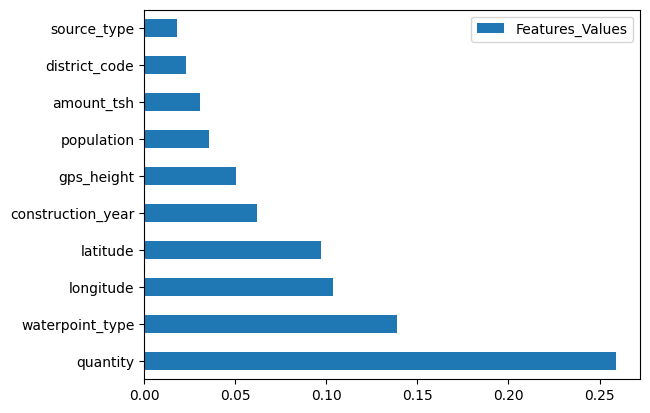

In [42]:
feature_impo = model_dt['decisiontreeclassifier'].feature_importances_
feature_names = X_train.columns

feature_impo_df = pd.DataFrame(feature_impo,
                               columns = ['Features_Values'],
                               index = feature_names).sort_values(by='Features_Values', ascending = False)

feature_impo_df.head(10).plot(kind = 'barh')